In [5]:
import numpy as np

# ============================================================
# 0) 設定（ビン化に必要な最小）
# ============================================================
NPZ_PATH = "dataset_irregular.npz"
L_GRID   = 256
SEED     = 0

np.random.seed(SEED)

# ============================================================
# 1) 読み込み（1サンプル=[cycle_id, deg, s1, label]）
# ============================================================
d = np.load(NPZ_PATH, allow_pickle=True)
train_list = d["train_list"].tolist()
test_list  = d["test_list"].tolist()

def group_by_cycle(sample_list):
    """
    sample_list を cycle_id ごとにまとめて dict にする
    dict[cid] = (deg_array, y_array, label)
    """
    arr = np.asarray(sample_list, dtype=object)
    cid = arr[:,0].astype(int)
    deg = arr[:,1].astype(float)
    y   = arr[:,2].astype(float)
    lab = arr[:,3].astype(int)

    # cycle_id -> deg の順に並べる（後の処理が安定）
    order = np.lexsort((deg, cid))
    cid, deg, y, lab = cid[order], deg[order], y[order], lab[order]

    cycles = {}
    start = 0
    while start < len(cid):
        c = int(cid[start])
        end = start
        while end < len(cid) and int(cid[end]) == c:
            end += 1
        cycles[c] = (deg[start:end], y[start:end], int(lab[start]))
        start = end
    return cycles

train_cycles = group_by_cycle(train_list)
test_cycles  = group_by_cycle(test_list)

def count_labels_from_cycles(cycles_dict):
    labs = np.array([lab for (_,_,lab) in cycles_dict.values()], dtype=int)
    u, c = np.unique(labs, return_counts=True)
    return {int(k): int(v) for k, v in zip(u, c)}

print("\n[cycle counts]")
print("train cycles total:", len(train_cycles))
print("test  cycles total:", len(test_cycles))
print("train label counts:", count_labels_from_cycles(train_cycles))
print("test  label counts:", count_labels_from_cycles(test_cycles))


[cycle counts]
train cycles total: 700
test  cycles total: 1020
train label counts: {0: 700}
test  label counts: {0: 720, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


# 説明（bin_cycle_nan がやっていること）

## 目的
不等間隔サンプル（角度 `deg[i]` と値 `y[i]`）を、0〜360度を `L` 個に分けた「升目（ビン）」に入れて  
**1サイクル = 長さ L の配列**に変換する。  
そのビンにデータが1点も無い場合は **欠損**として `NaN` のまま残す。

出力は次の3つ。
- `x_bin[b]`：ビン `b` の平均値（欠損はNaN）
- `mask[b]`：観測あり=1 / 欠損=0
- `cnt[b]`：ビン `b` に入った生点数

---

## 1) 角度を円環として正規化する
0度と360度は同じなので、角度は円環として扱う。  
コードの
`deg % 360.0`
は数式で

$deg'_i = deg_i \bmod 360$

を意味し、必ず $deg'_i \in [0,360)$ に入る。

例：
- $deg=-10^\circ \Rightarrow deg'=350^\circ$
- $deg=370^\circ \Rightarrow deg'=10^\circ$

---

## 2) 角度 → ビン番号へ変換する
0〜360度を `L` 個に等分するので、ビン幅は

$\Delta = \dfrac{360}{L}$ [deg]

各点 $deg'_i$ が入るビン番号は

$idx_i = \left\lfloor \dfrac{deg'_i}{360}L \right\rfloor
      = \left\lfloor \dfrac{deg'_i}{\Delta} \right\rfloor$

で、$idx_i \in \{0,1,\dots,L-1\}$。

---

## 3) ビンごとの合計と点数を集計する（数式が読める形＋数値例）

### 数式（表示されやすい形）
ビン番号を `idx[i]`、値を `y[i]` とします。  
ビン `b`（0〜L-1）について

- 合計（sumv）
  
  $
  \mathrm{sumv}[b] = \sum_{\{i \mid \mathrm{idx}[i] = b\}} y[i]
  $

- 個数（cnt）
  
  $
  \mathrm{cnt}[b] = \left|\{ i \mid \mathrm{idx}[i] = b \}\right|
  $

意味：
- `idx[i]=b` の点だけを集めて、その `y[i]` を全部足したものが `sumv[b]`
- `idx[i]=b` の点が何個あるかが `cnt[b]`

---

### 数値例（手で追える）

L=8（ビン0〜7）として、次の不等間隔データをビン化します。

- deg = [10, 20, 55, 130, 131, 220, 300]
- y   = [ 1,  2,  3,   4,   6,   5,   7]

ビン幅は 360/8=45° なので、ビン番号は `idx = floor(deg/45)` です。

| i | deg[i] | y[i] | idx[i]=floor(deg/45) | 入るビン |
|---|--------|------|-----------------------|----------|
| 0 | 10     | 1    | 0                     | bin0     |
| 1 | 20     | 2    | 0                     | bin0     |
| 2 | 55     | 3    | 1                     | bin1     |
| 3 | 130    | 4    | 2                     | bin2     |
| 4 | 131    | 6    | 2                     | bin2     |
| 5 | 220    | 5    | 4                     | bin4     |
| 6 | 300    | 7    | 6                     | bin6     |

ここから `sumv[b]` と `cnt[b]` を作ります。

#### bin0（b=0）
idx[i]=0 の行は i=0,1  
- sumv[0] = y[0] + y[1] = 1 + 2 = 3  
- cnt[0]  = 2（2点）

#### bin1（b=1）
idx[i]=1 の行は i=2  
- sumv[1] = y[2] = 3  
- cnt[1]  = 1

#### bin2（b=2）
idx[i]=2 の行は i=3,4  
- sumv[2] = y[3] + y[4] = 4 + 6 = 10  
- cnt[2]  = 2

#### bin3（b=3）
idx[i]=3 の行は無い  
- sumv[3] = 0（足すものが無いので初期値のまま）  
- cnt[3]  = 0

#### bin4（b=4）
idx[i]=4 の行は i=5  
- sumv[4] = 5  
- cnt[4]  = 1

#### bin5（b=5）
無い  
- sumv[5] = 0  
- cnt[5]  = 0

#### bin6（b=6）
idx[i]=6 の行は i=6  
- sumv[6] = 7  
- cnt[6]  = 1

#### bin7（b=7）
無い  
- sumv[7] = 0  
- cnt[7]  = 0

よって最終的に

- cnt  = [2, 1, 2, 0, 1, 0, 1, 0]
- sumv = [3, 3,10, 0, 5, 0, 7, 0]

この後に平均を作ると

- x_bin[b] = sumv[b]/cnt[b]（cnt[b]>0のとき）
- 欠損（cnt[b]=0）は NaN

となります。

---

## 4) ビン平均（欠損はNaN）とマスクを作る
観測があるビンを

$mask[b] =
\begin{cases}
1 & (cnt[b] > 0)\\
0 & (cnt[b] = 0)
\end{cases}$

とし、平均値を

$x_{bin}[b] =
\begin{cases}
\dfrac{sumv[b]}{cnt[b]} & (cnt[b] > 0)\\
NaN                     & (cnt[b] = 0)
\end{cases}$

で作る。

---

# 具体的な数値例（L=8）

## 入力
$L=8$ なので $\Delta=360/8=45^\circ$。

不等間隔データ：
- `deg = [10, 20, 55, 130, 131, 220, 300]`
- `y   = [1,  2,  3,  4,   6,   5,   7 ]`

## ビン番号
$idx=\lfloor deg/45 \rfloor$ より
- 10,20 → bin0
- 55 → bin1
- 130,131 → bin2
- 220 → bin4
- 300 → bin6

よって `idx = [0,0,1,2,2,4,6]`

## 集計
- `cnt = [2,1,2,0,1,0,1,0]`
- `sumv= [3,3,10,0,5,0,7,0]`

## 出力（平均）
- `x_bin = [3/2, 3/1, 10/2, NaN, 5/1, NaN, 7/1, NaN]`
- `x_bin = [1.5, 3.0, 5.0, NaN, 5.0, NaN, 7.0, NaN]`
- `mask  = [1,1,1,0,1,0,1,0]`

この `x_bin/mask/cnt` が「ビン化した結果（補間なし）」。


In [6]:
# ============================================================
# 2) ビン化（補間なし） + 信頼度（可視化なし）
#   目的：
#     不等間隔サンプル (deg, y) を
#     「0〜360度を L_GRID 個に分けた升目（ビン）」へ入れて
#     1サイクル = 長さL_GRIDの配列 に変換する
#
#   出力（1サイクルあたり）：
#     x_bin : 各ビンの平均値（そのビンにデータが無い=欠損は NaN）
#     mask  : 観測あり=1 / 欠損=0
#     cnt   : 各ビンに入った生データ点数（何点入ったか）
#
#   さらに、ビン化の「信頼度」を数値化：
#     coverage    : 観測ありビンの割合（= maskの平均）
#     miss_rate   : 欠損ビンの割合（= 1-coverage）
#     longest_gap : 欠損(0)が連続する最大長（円環を考慮）
#     n_obs       : そのサイクルの生データ点数
# ============================================================

deg_grid = np.linspace(0, 360, L_GRID, endpoint=False).astype(float)
deg_step = float(deg_grid[1] - deg_grid[0])  # 例：L_GRID=256なら約1.40625度

def bin_cycle_nan(deg, y, L=L_GRID):
    """
    1サイクル分の不等間隔データ (deg, y) をビン化する。

    入力：
      deg : 角度配列（不等間隔、0〜360度）
      y   : 値配列（degと同じ長さ）
      L   : ビン数（=L_GRID）

    手順：
      1) deg を [0,360) に丸める（負や360以上が来ても円環として扱う）
      2) 各degをビン番号 idx に変換する
         - 0度 -> idx=0
         - 359.9度 -> idx=L-1
      3) 同じビンに複数点が入ることがあるので
         - sumv[bin] に値を足し込む
         - cnt[bin]  に点数を足し込む
      4) cnt>0 のビンだけ平均を計算して x_bin に入れる
         欠損ビンは NaN のままにする
    """
    # ---- 1) 角度を円環として [0,360) に正規化 ----
    deg = np.asarray(deg, float) % 360.0
    y   = np.asarray(y, float)

    # ---- 2) deg -> ビン番号 idx ----
    # deg/360 は [0,1) に入るので、*Lして floor すると 0..L-1
    idx = np.floor(deg / 360.0 * L).astype(int)

    # 安全のため（degが360に非常に近いなどで）範囲外をクリップ
    idx = np.clip(idx, 0, L-1)

    # ---- 3) ビンごとの合計値と点数を作る ----
    sumv = np.zeros(L, float)   # ビンごとの y 合計
    cnt  = np.zeros(L, int)     # ビンごとの 点数

    # np.add.at は「同じidxが何回出ても正しく加算」してくれる
    np.add.at(sumv, idx, y)
    np.add.at(cnt,  idx, 1)

    # ---- 4) 平均値（欠損はNaN）とマスク ----
    mask = (cnt > 0).astype(np.int8)    # 観測あり=1, 欠損=0

    x_bin = np.full(L, np.nan, float)   # まず全部NaN（欠損扱い）
    # 観測ありビンだけ平均を入れる
    x_bin[mask == 1] = sumv[mask == 1] / cnt[mask == 1]

    return x_bin, mask, cnt


def longest_gap_circular(mask):
    """
    欠損(0)が連続する最大長（円環を考慮）。

    例（L=8）：
      mask = [1,1,0,0,0,1,1,1]
      欠損連続は t=2..4 の3つ → longest_gap=3

    円環を考慮するので、
      mask = [0,0,1,1,1,1,1,0]
      末尾の0と先頭の0がつながり欠損が3連続 → longest_gap=3
    """
    m = np.asarray(mask, int)
    L = len(m)

    # 全部欠損なら最大長はL
    if m.sum() == 0:
        return int(L)

    # 欠損を1、観測を0として並べる
    z = (m == 0).astype(int)

    # 円環を見るために2回つなげる（長さ2L）
    zz = np.r_[z, z]

    # 連続する1の最大長を数える
    best = 0
    cur  = 0
    for v in zz:
        if v == 1:
            cur += 1
            if cur > best:
                best = cur
        else:
            cur = 0

    # 円環なので最大でもLに制限
    return int(min(best, L))


def build_binned_nan(cycles_dict, L=L_GRID):
    """
    cycles_dict（train_cycles/test_cycles）全体をビン化して
    (Nサイクル, L_GRID) の行列にする。

    入力：
      cycles_dict: {cycle_id: (deg_array, y_array, label)}

    出力：
      Xnan : shape (N, L)  ビン平均（欠損はNaN）
      M    : shape (N, L)  欠損マスク
      Cnt  : shape (N, L)  ビン内点数
      ylab : shape (N,)    サイクルラベル
      cids : shape (N,)    cycle_id（昇順）
      rel  : dict          信頼度配列（coverage等）
    """
    # cycle_idを昇順に固定して、配列の行と対応づける
    cids = np.array(sorted(cycles_dict.keys()), dtype=int)
    N = len(cids)

    # 出力配列を確保
    Xnan = np.full((N, L), np.nan, float)  # 値（欠損はNaN）
    M    = np.zeros((N, L), np.int8)       # mask
    Cnt  = np.zeros((N, L), int)           # count
    ylab = np.zeros(N, int)                # label

    # 信頼度（1サイクル=1値）
    coverage   = np.zeros(N, float)  # 観測ありビンの割合
    miss_rate  = np.zeros(N, float)  # 欠損割合
    longest_gp = np.zeros(N, int)    # 連続欠損最大長
    n_obs      = np.zeros(N, int)    # 観測ありビン数（maskの1の数）
    n_raw      = np.zeros(N, int)    # 生データ点数（不等間隔点の数）

    for i, cid in enumerate(cids):
        deg, y, lab = cycles_dict[int(cid)]

        # ---- ビン化（補間なし）----
        x_bin, mask, cnt = bin_cycle_nan(deg, y, L)

        # 行列に格納（i行目がcidのサイクル）
        Xnan[i] = x_bin
        M[i]    = mask
        Cnt[i]  = cnt
        ylab[i] = int(lab)

        # ---- 信頼度 ----
        # coverage = 観測ありビン割合（maskの平均）
        cov = float(mask.mean())
        coverage[i]  = cov
        miss_rate[i] = 1.0 - cov

        # 欠損が固まっているか（円環）
        longest_gp[i] = longest_gap_circular(mask)

        # そのサイクルの生データ点数（不等間隔点の数）
        n_obs[i] = int(mask.sum())

        # 生データ点数（不等間隔点の数）
        n_raw[i] = int(len(deg))

    rel = {
        "coverage": coverage,
        "miss_rate": miss_rate,
        "longest_gap": longest_gp,
        "n_obs": n_obs,
        "n_raw": n_raw,
    }
    return Xnan, M, Cnt, ylab, cids, rel


# ---- 実行：train/test をビン化（補間なし）----
Xtr_nan, Mtr, Ctr, ytr, cidtr, rel_tr = build_binned_nan(train_cycles, L_GRID)
Xte_nan, Mte, Cte, yte, cidte, rel_te = build_binned_nan(test_cycles,  L_GRID)

# ---- 簡易ログ（動作確認）----
print("\n[binned (NaN kept)]")
print("Xtr_nan:", Xtr_nan.shape, "Mtr:", Mtr.shape, "Ctr:", Ctr.shape)
print("Xte_nan:", Xte_nan.shape, "Mte:", Mte.shape, "Cte:", Cte.shape)

print("\n[reliability summary: train]")
print("coverage mean/min:", float(rel_tr["coverage"].mean()), float(rel_tr["coverage"].min()))
print("miss_rate mean/max:", float(rel_tr["miss_rate"].mean()), float(rel_tr["miss_rate"].max()))
print("longest_gap mean/max:", float(rel_tr["longest_gap"].mean()), int(rel_tr["longest_gap"].max()))
print("n_obs (bins) mean/min:", float(rel_tr["n_obs"].mean()), int(rel_tr["n_obs"].min()))
print("n_raw (points) mean/min:", float(rel_tr["n_raw"].mean()), int(rel_tr["n_raw"].min()))


[binned (NaN kept)]
Xtr_nan: (700, 256) Mtr: (700, 256) Ctr: (700, 256)
Xte_nan: (1020, 256) Mte: (1020, 256) Cte: (1020, 256)

[reliability summary: train]
coverage mean/min: 0.9405078125 0.8984375
miss_rate mean/max: 0.0594921875 0.1015625
longest_gap mean/max: 1.0 1
n_obs (bins) mean/min: 240.77 230
n_raw (points) mean/min: 256.0 256


C:\Users\tsenz\AppData\Local\Temp\ipykernel_10012\2474136103.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


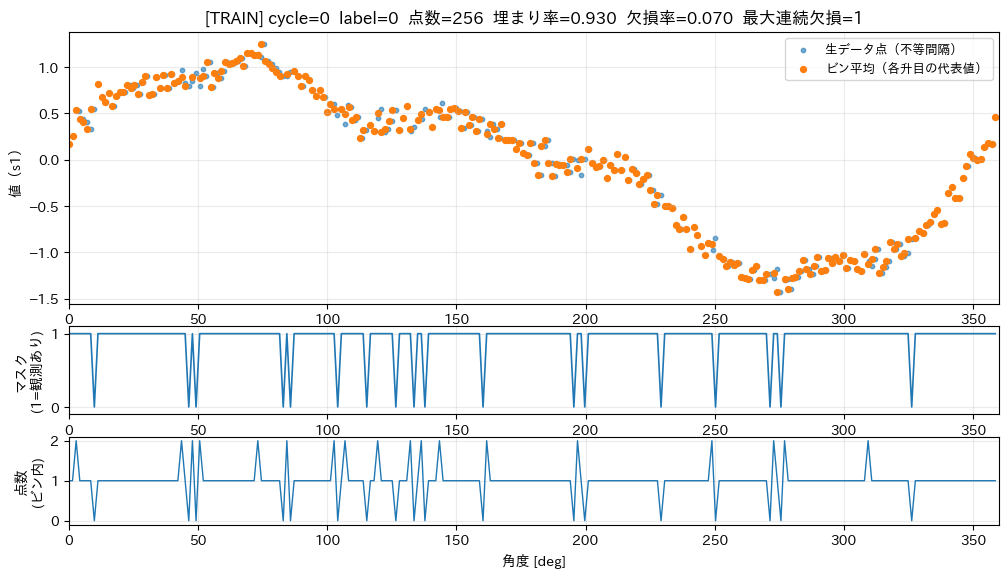

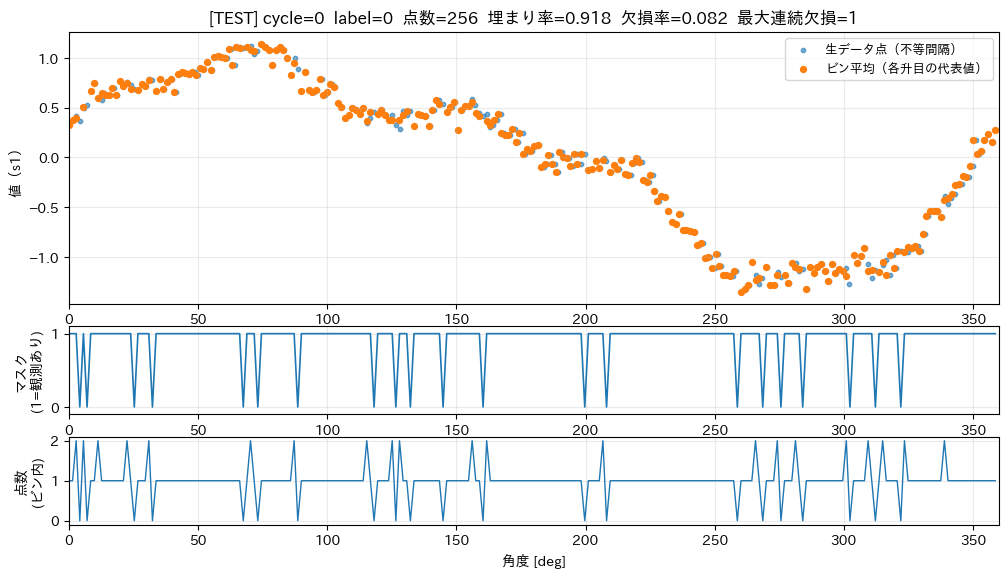

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# ============================================================
# 可視化 1) 代表1サイクル：生データ点 vs ビン化結果（補間なし）
# ============================================================
def plot_cycle_raw_vs_binned(cycles_dict, cid, L=L_GRID, タイトル接頭=""):
    deg_raw, y_raw, lab = cycles_dict[int(cid)]
    x_bin, mask, cnt = bin_cycle_nan(deg_raw, y_raw, L)

    cov  = float(mask.mean())
    miss = 1.0 - cov
    lg   = longest_gap_circular(mask)
    n    = int(len(deg_raw))

    fig = plt.figure(figsize=(12, 6.4))
    gs = fig.add_gridspec(3, 1, height_ratios=[3.4, 1.1, 1.1], hspace=0.15)

    ax0 = fig.add_subplot(gs[0])
    ax0.scatter(deg_raw, y_raw, s=10, alpha=0.6, label="生データ点（不等間隔）")
    ax0.scatter(deg_grid[mask==1], x_bin[mask==1], s=18, label="ビン平均（各升目の代表値）")
    ax0.set_xlim(0, 360)
    ax0.set_xlabel("角度 [deg]")
    ax0.set_ylabel("値（s1）")
    ax0.set_title(f"{タイトル接頭} cycle={cid}  label={lab}  点数={n}  埋まり率={cov:.3f}  欠損率={miss:.3f}  最大連続欠損={lg}")
    ax0.grid(True, alpha=0.25)
    ax0.legend(loc="upper right", fontsize=9)

    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    ax1.plot(deg_grid, mask, linewidth=1.2)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_yticks([0,1])
    ax1.set_ylabel("マスク\n(1=観測あり)")
    ax1.grid(True, alpha=0.25)

    ax2 = fig.add_subplot(gs[2], sharex=ax0)
    ax2.plot(deg_grid, cnt, linewidth=1.0)
    ax2.set_ylabel("点数\n(ビン内)")
    ax2.set_xlabel("角度 [deg]")
    ax2.grid(True, alpha=0.25)

    plt.tight_layout()
    plt.show()




# ============================================================
# 実行例
# ============================================================
train_normal_cids = [cid for cid,(deg,y,lab) in train_cycles.items() if lab == 0]
if len(train_normal_cids) > 0:
    cid0 = train_normal_cids[0]
    plot_cycle_raw_vs_binned(train_cycles, cid0, L_GRID, タイトル接頭="[TRAIN]")

cid1 = list(test_cycles.keys())[0]
plot_cycle_raw_vs_binned(test_cycles, cid1, L_GRID, タイトル接頭="[TEST]")



# 特徴量の算出

記号の約束（表内で使う）
L は 1サイクルのビン数。m[i] は観測あり=1、欠損=0 のマスク。
観測インデックス集合を $O=\{\,i\in\{0,\dots,L-1\}\mid m[i]=1\,\}$ とする。
「Oの個数（観測点数）」は $n_{\mathrm{obs}}=\sum_{i=0}^{L-1} m[i]$ と書く（表内ではこの形で書く）。

## 記号の読み方（abs と 個数を混同しないための統一）
| 表記 | 意味 | 例 |
|---|---|---|
| $\mathrm{abs}(a)$ | 絶対値（大きさ） | $\mathrm{abs}(-3)=3$ |
| $\mathrm{count}(S)$ | 集合 $S$ の要素数（個数） | $\mathrm{count}(\{2,5,8\})=3$ |
| $\sum_{i\in S}$ | $S$ に入っている $i$ だけ足す | $\sum_{i\in\{1,3\}} f(i)=f(1)+f(3)$ |

---

## 共通の下ごしらえ（ビン化系で共通に使う定義）
| 名前 | 定義 |
|---|---|
| ビン波形 | $x_{\mathrm{bin}}[i]\quad (i=0,\dots,L-1)$ |
| ビンマスク | $m[i]\in\{0,1\}$（観測あり$=1$、欠損$=0$） |
| 参照波形 | $x_{\mathrm{ref}}[i]\quad (i=0,\dots,L-1)$ |
| 参照マスク | $m_{\mathrm{ref}}[i]$（通常は全て$1$でもよい） |
| 比較できる位置集合 | $\mathrm{ok}=\{\, i \mid m[i]=1,\ m_{\mathrm{ref}}[i]=1,\ x_{\mathrm{bin}}[i],x_{\mathrm{ref}}[i]\ \text{が有限}\,\}$ |
| ok上の平均 | $\mathrm{mean}_{\mathrm{ok}}(z)=\dfrac{1}{\mathrm{count}(\mathrm{ok})}\sum_{i\in \mathrm{ok}} z[i]$ |
| 円環シフト | $\mathrm{roll}(x,s)[i]=x[(i-s)\bmod L]$（この定義に合わせて符号を統一） |
| ok上の相関 | $\mathrm{corr}_{\mathrm{ok}}(x,y)=\dfrac{A}{\sqrt{B_x}\sqrt{B_y}}$<br>$A=\sum_{i\in\mathrm{ok}}(x[i]-\mathrm{mean}_{\mathrm{ok}}(x))(y[i]-\mathrm{mean}_{\mathrm{ok}}(y))$<br>$B_x=\sum_{i\in\mathrm{ok}}(x[i]-\mathrm{mean}_{\mathrm{ok}}(x))^2$<br>$B_y=\sum_{i\in\mathrm{ok}}(y[i]-\mathrm{mean}_{\mathrm{ok}}(y))^2$ |

---

## 特徴量の数式（abs と count を明示）
| 区分 | 特徴量名 | ビン化必要？ | 入力（推奨形） | 定義（数式） | 注意（欠損/信頼度の扱い） |
|---|---|---:|---|---|---|
| 信頼度 | coverage | はい | $m[0..L-1]$ | $\mathrm{coverage}=\dfrac{1}{L}\sum_{i=0}^{L-1} m[i]$ | ゲート用（MSPCに混ぜない推奨）。 |
| 信頼度 | miss_rate | はい | $m[\ ]$ | $\mathrm{miss\_rate}=1-\mathrm{coverage}$ | coverageと同情報。どちらか片方。 |
| 信頼度 | n_obs | はい | $m[\ ]$ | $n_{\mathrm{obs}}=\sum_{i=0}^{L-1} m[i]$ | coverageと比例（$n_{\mathrm{obs}}=L\cdot\mathrm{coverage}$）。 |
| 信頼度 | longest_gap | はい | $m[\ ]$ | $\mathrm{longest\_gap}=\max(\text{「}m[i]=0\text{ の連続長」})$ | 円環として数えるか（端も連結）を実装で固定。 |
| 異常（横ずれ） | phase_shift_deg | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $s^*=\arg\max_{s=0,\dots,L-1}\ \mathrm{corr}_{\mathrm{ok}}\!\left(x_{\mathrm{ref}},\ \mathrm{roll}(x_{\mathrm{bin}},s)\right)$<br>$\mathrm{phase\_shift\_deg}=\dfrac{360}{L}\,s^*$ | 0/360近傍の折返しが必要なら $\mathrm{wrap}_{180}(\phi)=((\phi+180)\bmod 360)-180$。 |
| 異常（横ずれ信頼度） | phase_corr_max | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $\mathrm{phase\_corr\_max}=\max_{s=0,\dots,L-1}\ \mathrm{corr}_{\mathrm{ok}}\!\left(x_{\mathrm{ref}},\ \mathrm{roll}(x_{\mathrm{bin}},s)\right)$ | 低いと位相推定が怪しい→ゲートに使える。 |
| 異常（上下） | offset_abs | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $x_{\mathrm{al}}=\mathrm{roll}(x_{\mathrm{bin}},s^*)$<br>$\mathrm{offset}=\mathrm{mean}_{\mathrm{ok}}(x_{\mathrm{al}}-x_{\mathrm{ref}})$<br>$\mathrm{offset\_abs}=\mathrm{abs}(\mathrm{offset})$ | ok上で平均との差（欠損はokで排除）。 |
| 異常（形状） | shape_rms | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $x_{\mathrm{al}}=\mathrm{roll}(x_{\mathrm{bin}},s^*)$<br>$\mathrm{offset}=\mathrm{mean}_{\mathrm{ok}}(x_{\mathrm{al}}-x_{\mathrm{ref}})$<br>$x_{\mathrm{corr}}=x_{\mathrm{al}}-\mathrm{offset}$<br>$r=x_{\mathrm{corr}}-x_{\mathrm{ref}}$<br>$\mathrm{shape\_rms}=\sqrt{\mathrm{mean}_{\mathrm{ok}}(r^2)}$ | スパイクに弱ければ $r$ をクリップ/トリムしてからRMS。 |
| 異常（形状） | shape_1minus_corr | はい | $x_{\mathrm{bin}}[\ ],\ x_{\mathrm{ref}}[\ ]$（＋$m,m_{\mathrm{ref}}$） | $x_{\mathrm{al}}=\mathrm{roll}(x_{\mathrm{bin}},s^*)$<br>$\mathrm{offset}=\mathrm{mean}_{\mathrm{ok}}(x_{\mathrm{al}}-x_{\mathrm{ref}})$<br>$x_{\mathrm{corr}}=x_{\mathrm{al}}-\mathrm{offset}$<br>$\mathrm{shape\_1minus\_corr}=1-\mathrm{corr}_{\mathrm{ok}}(x_{\mathrm{corr}},x_{\mathrm{ref}})$ | RMSと補完関係。どちらか1本なら shape_rms が扱いやすいことが多い。 |
| 異常（スパイク強さ） | spike_max | はい | $r[\ ]$（残差）＋ok | $r=(\mathrm{roll}(x_{\mathrm{bin}},s^*)-\mathrm{offset})-x_{\mathrm{ref}}$<br>$\mathrm{spike\_max}=\max_{i\in\mathrm{ok}}\ \mathrm{abs}(r[i])$ | 単発ノイズにも反応しやすい。 |
| 異常（スパイク数） | spike_count | はい | $r[\ ]$（残差）＋ok | $r_{\mathrm{med}}=\mathrm{median}_{i\in\mathrm{ok}}(r[i])$<br>$\mathrm{MAD}=\mathrm{median}_{i\in\mathrm{ok}}\left(\mathrm{abs}(r[i]-r_{\mathrm{med}})\right)$<br>$\sigma_{\mathrm{rob}}=1.4826\,\mathrm{MAD}$<br>$\tau=k\,\sigma_{\mathrm{rob}}$<br>$\mathrm{spike\_count}=\sum_{i\in\mathrm{ok}} \mathbf{1}\!\left(\mathrm{abs}(r[i]-r_{\mathrm{med}})>\tau\right)$ | $k$は例として6など。正常calibで分位点調整が現実的。 |
| 異常（周波数：全体） | ls_hl（LS） | いいえ（ビン化なし推奨） | 不等間隔 $(\theta_j,x_j)$（$j=1,\dots,N$） | $u_j=\theta_j/360$<br>$\omega_k=2\pi k\quad (k=1,\dots,K)$<br>$P(k)=\mathrm{lombscargle}\!\left(u,\ x,\ \omega_k;\ \mathrm{floating\_mean}=\mathrm{True},\ \mathrm{normalize}=\text{"power"}\right)$<br>$Z(k)=\log(P(k)+\varepsilon)$<br>$\mathrm{ls\_hl}=\mathrm{mean}_{k\in\mathrm{High}} Z(k)-\mathrm{mean}_{k\in\mathrm{Low}} Z(k)$ | SciPyの $P(k)$ は periodogram（power）。$x$ にオフセット（平均のズレ）があり得るなら $\mathrm{floating\_mean}=\mathrm{True}$ を推奨。$\mathrm{normalize}$ は常に同じ設定で固定。必要なら振幅の目安：$A(k)=2\sqrt{P(k)/N}$（$\mathrm{normalize}=\text{"power"}$ のとき）。 |

### 推奨セット（MSPC入力に入れる最小構成）
- offset_abs
- phase_shift_deg
- phase_corr_max
- cwt_hl
- shape_rms
- spike_max
- spike_count

### 推奨セット（MSPCに入れない＝ゲート/ログ用）
- coverage
- longest_gap
- n_obs
（miss_rateはcoverageの代替なので通常不要）


# 特徴量の算出（実装）

この節では、次の順番で実装する。

1. Lomb–Scargle（SciPy）で次数スペクトル \(P(k)\) を計算する（不等間隔の生データをそのまま使う）
2. LSスペクトルから周波数特徴量（ls_low / ls_mid / ls_high / ls_hl / ls_ml）を作る
3. ビン化波形から、位相整列・上下補正を行い、残差ベースの特徴量（offset_abs, shape_*, spike_*）を作る

以降の関数は「特徴量1つ = 関数1つ」を基本にし、重複計算が必要な部分（位相推定・残差計算など）は内部の共通関数でまとめる。


## 1) Lomb–Scargle（LS）関連

ここでは角度を **正規化** して

$
x_j = (deg_j mod 360)/360 \in [0,1)
$

とし、次数 \(k\) に対応する角周波数を

$
\omega_k = 2\pi k
$

として SciPy の Lomb–Scargle を計算する。

SciPy が返すパワーを \(P(k)\) と書き、対数変換

$
Z(k)=\log(P(k)+
arepsilon)
$

を使って帯域平均を作る。


k は $k_{min}$〜$k_{max}$（刻み $k_{step}$）で指定するか、配列 $k_{grid}$ を直接与えて指定できる。


In [8]:
import numpy as np
from scipy.signal import lombscargle

# ============================================================
# LS 1) 周波数（次数）スペクトル P(k) を計算する（SciPy）
# ============================================================
def ls_power_scipy_from_deg(
    deg_raw,
    y_raw,
    k_min=1,
    k_max=100,
    k_step=1,
    k_grid=None,
    eps=1e-12,
    precenter=True,
    normalize=True,
):
    """
    不等間隔の角度データ (deg_raw, y_raw) から、次数 k の Lomb–Scargle パワー P(k) を計算する。

    重要：この関数は「LSスペクトルを出すだけ」。
          特徴量（ls_hl など）は別関数（ls_features_from_power）で作る。

    入力
    ----
    deg_raw : array-like
        角度 [deg]（不等間隔）。0〜360外でもOK（円環として扱う）。
    y_raw : array-like
        値（deg_raw と同じ長さ）。
    k_min, k_max, k_step : int
        計算したい次数 k の範囲（k_min..k_max を k_step 刻み）。
        例：k_min=1, k_max=100, k_step=1
        ※ k_grid を与えた場合は無視される。
    k_grid : array-like or None
        計算したい次数 k を「配列で直接」与える。
        例：k_grid=[1,2,3,5,8,13,...]
        None のときは (k_min,k_max,k_step) から作る。
    eps : float
        0除算・log(0)回避用の小さい値（この関数では主に安全策）。
    precenter : bool
        True なら SciPy 側で y の平均を引いてから計算（推奨）。
    normalize : bool
        True なら SciPy の規約で正規化したパワーを返す。

    出力
    ----
    k_grid : ndarray shape (K,)
        次数の配列（整数）。
    Pk : ndarray shape (K,)
        Lomb–Scargle のパワー（非負）。

    実装メモ
    --------
    SciPy の lombscargle(x, y, omega, ...) は
        y ≈ a cos(omega x) + b sin(omega x)
    を各 omega で最小二乗フィットし、そのパワーを返す。

    ここでは「1回転（0〜360度）」を x∈[0,1) に正規化しているため、
      次数 k に対応する基底は  cos(2πk x), sin(2πk x)
    となる。したがって
      omega_k = 2πk
    を使う。
    """
    # ---- 入力を ndarray にする（型と形を確定）----
    deg_raw = np.asarray(deg_raw, float)
    y_raw   = np.asarray(y_raw, float)

    # ---- 有効データ（有限値）だけに絞る（NaN/infを除外）----
    ok = np.isfinite(deg_raw) & np.isfinite(y_raw)
    deg = deg_raw[ok]
    y   = y_raw[ok]

    # ---- データ点が少なすぎると LS が不安定になるので弾く ----
    if y.size < 3:
        # k_grid を確定して、同じ長さの NaN を返す
        if k_grid is None:
            k_grid_out = np.arange(int(k_min), int(k_max) + 1, int(k_step), dtype=int)
        else:
            k_grid_out = np.asarray(k_grid, int)
        return k_grid_out, np.full_like(k_grid_out, np.nan, dtype=float)

    # ---- 角度を円環として [0,360) にし、さらに [0,1) に正規化 ----
    x = (deg % 360.0) / 360.0

    # ---- 次数配列を確定 ----
    if k_grid is None:
        k_grid = np.arange(int(k_min), int(k_max) + 1, int(k_step), dtype=int)
    else:
        k_grid = np.asarray(k_grid, int)

    # ---- 次数は 1以上に制限（k=0 は平均＝直流）----
    k_grid = k_grid[np.isfinite(k_grid)]
    k_grid = k_grid[k_grid >= 1]

    # ---- 重複があれば削除し、昇順にする ----
    if k_grid.size == 0:
        return np.asarray([], dtype=int), np.asarray([], dtype=float)
    k_grid = np.unique(k_grid)

    # ---- SciPy に渡す角周波数 omega を作る ----
    # x が [0,1) の「回転で正規化された軸」なので omega_k = 2πk
    omega = 2.0 * np.pi * k_grid.astype(float)

    # ---- Lomb–Scargle 計算（SciPy）----
    Pk = lombscargle(
        x,
        y,
        omega,
        precenter=bool(precenter),
        normalize=bool(normalize),
    )

    # ---- 安全策：わずかな負値が出たら 0 にクリップ（パワーは非負）----
    Pk = np.asarray(Pk, float)
    Pk = np.maximum(Pk, 0.0)

    # ---- 極端に小さい値は eps で下駄（log用の安全）----
    Pk = np.maximum(Pk, float(eps))

    return k_grid, Pk


# ============================================================
# LS 2) LSスペクトル P(k) から「周波数特徴量」を作る
# ============================================================
def ls_features_from_power(
    k_grid,
    Pk,
    low=(1, 10),
    mid=(11, 30),
    high=(31, 100),
    eps=1e-12,
):
    """
    LSパワー P(k) から、帯域平均と差分の特徴量を作る。

    入力
    ----
    k_grid : ndarray shape (K,)
        次数（整数）。
    Pk : ndarray shape (K,)
        LSパワー（非負）。
    low, mid, high : tuple(int,int)
        それぞれ (k_start, k_end) を含む区間。
        例：low=(1,10), mid=(11,30), high=(31,100)
    eps : float
        log(0) 回避用

    出力
    ----
    feat : dict
        ls_low, ls_mid, ls_high, ls_hl, ls_ml

    定義（簡易式）
    ------------
      Z(k) = log(P(k) + eps)
      ls_low  = mean_{k in Low}  Z(k)
      ls_mid  = mean_{k in Mid}  Z(k)
      ls_high = mean_{k in High} Z(k)
      ls_hl = ls_high - ls_low
      ls_ml = ls_mid  - ls_low
    """
    k_grid = np.asarray(k_grid, int)
    Pk     = np.asarray(Pk, float)

    if k_grid.size == 0 or Pk.size == 0:
        return {"ls_low": np.nan, "ls_mid": np.nan, "ls_high": np.nan, "ls_hl": np.nan, "ls_ml": np.nan}

    # ---- 対数変換（スケール変動に強くする）----
    Z = np.log(Pk + float(eps))

    # ---- 区間マスクを作る（kが範囲に入るか）----
    def in_range(k_start, k_end):
        return (k_grid >= int(k_start)) & (k_grid <= int(k_end))

    m_low  = in_range(*low)
    m_mid  = in_range(*mid)
    m_high = in_range(*high)

    # ---- 各帯域の平均（帯域内が空なら NaN）----
    def mean_or_nan(z, m):
        if np.any(m):
            return float(np.nanmean(z[m]))
        return float("nan")

    ls_low  = mean_or_nan(Z, m_low)
    ls_mid  = mean_or_nan(Z, m_mid)
    ls_high = mean_or_nan(Z, m_high)

    return {
        "ls_low":  ls_low,
        "ls_mid":  ls_mid,
        "ls_high": ls_high,
        "ls_hl":   float(ls_high - ls_low) if np.isfinite(ls_high) and np.isfinite(ls_low) else float("nan"),
        "ls_ml":   float(ls_mid  - ls_low) if np.isfinite(ls_mid)  and np.isfinite(ls_low) else float("nan"),
    }


## 2) ビン化波形（NaN + マスク）からの特徴量

位相（横ずれ）・上下（オフセット）・形状・スパイクは、**同じビン格子上で比較**する必要があるため、ビン化波形 \(x[i]\) と参照波形 \(x_{ref}[i]\) を使う。

この節では、まず「参照波形」を作り、次に位相推定（相関最大）で整列し、整列後にオフセットと残差 \(r\) を作って特徴量を計算する。


### 記号とデータ行列（コードに対応）

1サイクルのビン数を $L$ とする。  
1サイクルの波形（1次元配列）を

$ x = [x_0, x_1, \dots, x_{L-1}]^\top \in \mathbb{R}^L $

マスク（観測あり=1, 欠損=0）を

$ m = [m_0, m_1, \dots, m_{L-1}]^\top \in \{0,1\}^L $

とする。観測インデックス集合は

$ O = \{\, i\in\{0,\dots,L-1\}\mid m_i=1 \ \wedge\ x_i \text{が有限}\,\} $

（コードの `ok = (m==1) & isfinite(x)` に一致）。

複数サイクルをまとめたデータ行列も明示すると、

$ X = [x^{(1)}, x^{(2)}, \dots, x^{(N)}]^\top \in \mathbb{R}^{N\times L} $

$ M = [m^{(1)}, m^{(2)}, \dots, m^{(N)}]^\top \in \{0,1\}^{N\times L} $

ここで $x^{(n)}\in\mathbb{R}^L$ は n番目サイクル、$m^{(n)}\in\{0,1\}^L$ はそのマスク。

---

### 1) `_masked_values(x, mask)` の数式

コードは「mask==1 かつ有限値」だけ取り出して 1次元に並べる処理。

$v = \{ x_i \mid i\in O\}$ を “取り出した値の列” として、

$ \mathrm{masked\_values}(x,m) = (x_i)_{i\in O} \in \mathbb{R}^{|O|} $

---

### 2) `_masked_mean(x, mask)` の数式

$O$ が空なら NaN（未定義）を返す。

$ \mathrm{masked\_mean}(x,m) =
\begin{cases}
\frac{1}{|O|}\sum_{i\in O} x_i, & |O|>0 \\
\mathrm{NaN}, & |O|=0
\end{cases}
$

---

### 3) `_masked_corr(x, y, mask)` の数式（Pearson相関）

入力は $x,y\in\mathbb{R}^L$ と共通マスク $m\in\{0,1\}^L$。  
コードは「mask==1 かつ両方有限」の点だけで相関を計算。

$ O_{xy} = \{\, i\mid m_i=1 \ \wedge\ x_i,y_i\text{が有限}\,\} $

要素数が3未満なら NaN（コードの `if xv.size < 3`）。

平均（マスク付き）を

$ \bar{x} = \frac{1}{|O_{xy}|}\sum_{i\in O_{xy}} x_i,\quad
\bar{y} = \frac{1}{|O_{xy}|}\sum_{i\in O_{xy}} y_i $

中心化した値を

$ \tilde{x}_i = x_i-\bar{x},\quad \tilde{y}_i = y_i-\bar{y} \quad (i\in O_{xy}) $

とすると、相関は

$ \mathrm{masked\_corr}(x,y,m)=
\begin{cases}
\frac{\sum_{i\in O_{xy}} \tilde{x}_i\tilde{y}_i}
{\sqrt{\sum_{i\in O_{xy}}\tilde{x}_i^2}\ \sqrt{\sum_{i\in O_{xy}}\tilde{y}_i^2}}, &
|O_{xy}|\ge 3,\ \sqrt{\sum \tilde{x}_i^2}\sqrt{\sum \tilde{y}_i^2}>0 \\
\mathrm{NaN}, & \text{それ以外}
\end{cases}
$

「分母が0（分散ゼロ）」の場合に NaN を返すのが、コードの `if den <= 0: return NaN` に対応。

---

### 4) `_masked_rms(x, mask)` の数式

RMS は二乗平均平方根。$O$ が空なら NaN。

$ \mathrm{masked\_rms}(x,m) =
\begin{cases}
\sqrt{\frac{1}{|O|}\sum_{i\in O} x_i^2}, & |O|>0 \\
\mathrm{NaN}, & |O|=0
\end{cases}
$

---

### （補足）コードの `ok` が意味するもの

`ok = (m==1) & isfinite(x)` は

$ i\in O \iff (m_i=1)\ \wedge\ (x_i\in\mathbb{R}) $

を作っている。つまり「マスクが1でも NaN/inf の点は除外」する設計。

In [9]:
import numpy as np

# ============================================================
# 共通：マスク付きの統計（平均・相関・RMSなど）
# ============================================================
def _masked_values(x, mask):
    """mask==1 かつ有限値の要素だけを 1次元 ndarray で返す。"""
    x = np.asarray(x, float)
    m = np.asarray(mask, int)
    ok = (m == 1) & np.isfinite(x)
    return x[ok]

def _masked_mean(x, mask):
    v = _masked_values(x, mask)
    if v.size == 0:
        return float("nan")
    return float(v.mean())

def _masked_corr(x, y, mask):
    """
    Pearson 相関係数 corr(x,y) を mask==1 の点だけで計算。
    分母が0（分散ゼロ）なら NaN。
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.asarray(mask, int)

    ok = (m == 1) & np.isfinite(x) & np.isfinite(y)
    xv = x[ok]
    yv = y[ok]
    if xv.size < 3:
        return float("nan")

    xv = xv - xv.mean()
    yv = yv - yv.mean()
    den = np.sqrt((xv*xv).sum()) * np.sqrt((yv*yv).sum())
    if den <= 0:
        return float("nan")
    return float((xv*yv).sum() / den)

def _masked_rms(x, mask):
    v = _masked_values(x, mask)
    if v.size == 0:
        return float("nan")
    return float(np.sqrt(np.mean(v*v)))


In [10]:


# ============================================================
# 信頼度（ビン化から直接）
# ============================================================
def feat_coverage(mask):
    """coverage = (1/L) * sum_i m[i]"""
    m = np.asarray(mask, int)
    return float(m.mean())

def feat_miss_rate(mask):
    """miss_rate = 1 - coverage"""
    return float(1.0 - feat_coverage(mask))

def feat_longest_gap(mask):
    """longest_gap = max(連続欠損長)（円環）"""
    return int(longest_gap_circular(mask))

def feat_n_obs(mask):
    """n_obs = sum_i m[i]（観測ありビン数）"""
    m = np.asarray(mask, int)
    return int(m.sum())


### 具体例：build_reference_waveform_from_train の計算（数値）

前提：
- 1サイクルのビン数：L=5
- train のサイクル数：N=4
- 正常ラベル：label_normal=0
- min_valid_per_bin=2（有効点が2未満のビンは参照を欠損扱い）

---

#### 1) 入力データ

ylab_tr（各サイクルのラベル）
- ylab_tr = [0, 0, 1, 0]
  → 正常サイクルは n=0,1,3（3本）

Xnan_tr（欠損は NaN）
- n=0: [ 1.0,  NaN,  3.0,  4.0,  NaN ]
- n=1: [ 2.0,  2.0,  NaN,  5.0,  NaN ]
- n=2: [ 9.0,  9.0,  9.0,  9.0,  9.0 ]   ← 異常なので参照作成には使わない
- n=3: [ NaN,  1.0,  3.0,  NaN,  NaN ]

M_tr（観測あり=1/欠損=0） ※この関数では直接は使っていない
- n=0: [1,0,1,1,0]
- n=1: [1,1,0,1,0]
- n=2: [1,1,1,1,1]
- n=3: [0,1,1,0,0]

---

#### 2) 正常サイクルだけ抽出

idx = (ylab_tr == 0) より、Xn は n=0,1,3 の3行だけ。

Xn =
- n=0: [ 1.0,  NaN,  3.0,  4.0,  NaN ]
- n=1: [ 2.0,  2.0,  NaN,  5.0,  NaN ]
- n=3: [ NaN,  1.0,  3.0,  NaN,  NaN ]

---

#### 3) valid と n_valid（NaNでない数のカウント）

valid = isfinite(Xn) をビンごとに見る（T=有効, F=欠損）

- ビン0： [T, T, F] → n_valid[0] = 2
- ビン1： [F, T, T] → n_valid[1] = 2
- ビン2： [T, F, T] → n_valid[2] = 2
- ビン3： [T, T, F] → n_valid[3] = 2
- ビン4： [F, F, F] → n_valid[4] = 0

よって
- n_valid = [2, 2, 2, 2, 0]

---

#### 4) x_ref = nanmean(Xn, axis=0)（NaNを無視した平均）

ビン0：有効値は 1.0 と 2.0 → 平均 = (1.0+2.0)/2 = 1.5  
ビン1：有効値は 2.0 と 1.0 → 平均 = (2.0+1.0)/2 = 1.5  
ビン2：有効値は 3.0 と 3.0 → 平均 = (3.0+3.0)/2 = 3.0  
ビン3：有効値は 4.0 と 5.0 → 平均 = (4.0+5.0)/2 = 4.5  
ビン4：有効値が0個 → nanmean は NaN

よって
- x_ref（暫定）= [1.5, 1.5, 3.0, 4.5, NaN]

---

#### 5) 有効数が少ないビンを欠損扱いにする（min_valid_per_bin=2）

条件：n_valid[i] < 2 なら x_ref[i]=NaN にする。

n_valid = [2,2,2,2,0] なので
- ビン4だけ 0 < 2 → 欠損のまま（NaN）

結果は変わらず
- x_ref = [1.5, 1.5, 3.0, 4.5, NaN]

---

#### 6) m_ref = isfinite(x_ref)

- m_ref = [1, 1, 1, 1, 0]（NaNのビン4は参照なし）

---

#### 出力まとめ

- x_ref = [1.5, 1.5, 3.0, 4.5, NaN]
- m_ref = [1,   1,   1,   1,   0]

In [11]:

# ============================================================
# 参照波形（x_ref）を作る：正常サイクルの NaN平均
# ============================================================
def build_reference_waveform_from_train(
    Xnan_tr,
    M_tr,
    ylab_tr,
    label_normal=0,
    min_valid_per_bin=10,
):
    """
    train の正常サイクルから参照波形 x_ref を作る（ビンごとに NaN平均）。

    入力
    ----
    Xnan_tr : (N,L)  ビン平均（欠損はNaN）
    M_tr    : (N,L)  観測あり=1/欠損=0
    ylab_tr : (N,)   サイクルラベル
    label_normal : int
        正常ラベル値
    min_valid_per_bin : int
        参照を作るとき、そのビンに有効点がこれ未満なら参照ビンも欠損扱いにする。

    出力
    ----
    x_ref : (L,) float
        参照波形（欠損はNaN）
    m_ref : (L,) int8
        参照マスク（参照が有効=1 / 欠損=0）
    """
    Xnan_tr = np.asarray(Xnan_tr, float)
    M_tr    = np.asarray(M_tr, int)
    ylab_tr = np.asarray(ylab_tr, int)

    # ---- 正常サイクルだけ抽出 ----
    idx = (ylab_tr == int(label_normal))
    Xn  = Xnan_tr[idx]

    # ---- ビンごとの有効数（NaNでない数）を数える ----
    valid = np.isfinite(Xn)
    n_valid = valid.sum(axis=0)

    # ---- NaN平均で参照を作る ----
    x_ref = np.nanmean(Xn, axis=0)

    # ---- 有効数が少ないビンは参照も欠損扱い ----
    x_ref[n_valid < int(min_valid_per_bin)] = np.nan

    m_ref = np.isfinite(x_ref).astype(np.int8)
    return x_ref, m_ref


| 関数 | 出力 | 何を意味するか（現場の言い方） | 目安（例） | 判断のしかた（運用ルール例） | よくある落とし穴 |
|---|---|---|---|---|---|
| `estimate_phase_shift_by_corr` | `s_star`（0..L-1 の整数） | 参照に一番似るように「入力に何ビンずらし（roll）をかけるか」 | L=256なら 1ビン≒360/256=1.406° | `phase_corr_max` が十分高いときだけ `s_star` を信用する | `s_star` は円環表現。例えば「-1ビン」相当が `L-1` として出るので直感とズレやすい |
| `estimate_phase_shift_by_corr` | `corr_max`（-1..1） | 「最も似るシフトを選んだ時の形の一致度」＝位相推定の信頼度 | 0.9以上: ほぼ同形、0.7〜0.9: そこそこ、0.5〜0.7: 怪しい、0.5未満: ほぼ合わない | 低いなら位相推定は不安定 → 位相系特徴量（`phase_shift_deg`）や整列後の shape_* を無効化（ゲート） | 欠損が多い/比較点が少ない/参照側が欠損/スパイクが多いと下がる。異常でも下がるので他特徴量と併用 |
| `feat_phase_shift_deg` | `phase_shift_deg`（度） | 「参照に合わせるために必要だった横ずれ量（角度）」 | 例：L=256で s_star=10 → 約14.1° | `phase_corr_max` が高いときだけ異常判定に使う。連続性が必要なら [-180,180] に折返して符号付きで扱う | 0/360付近で飛ぶ（例：1°と359°が遠く見える）。折返し処理を検討 |
| `feat_phase_corr_max` | `phase_corr_max`（-1..1） | 位相推定の「確からしさ」そのもの（ゲートに最適） | 上と同じ | 例：`phase_corr_max < 0.6` なら「位相推定不採用」→ `phase_shift_deg` を NaN にする / 整列後特徴量を計算しない / 判定保留 | 「位相ずれが大きいから低い」ではない。「どれだけずらしても似ない」と低くなる |

In [12]:


# ============================================================
# 位相推定：相関が最大になる円環シフト s* を求める
# ============================================================
import numpy as np

def estimate_phase_shift_by_corr(x_bin, m_bin, x_ref, m_ref):
    """
    目的
    ----
    参照波形 x_ref に対して、入力波形 x_bin を「円環シフト（np.roll）」して位置合わせする。
    そのとき「相関（形の似ている度）」が最大になるシフト量 s*（ビン単位）を探す。

    重要な定義（混乱しやすい点）
    ----------------------------
    s* は「入力波形 x_bin にそのまま適用するシフト量」として定義する。
        x_aligned = roll(x_bin, s*)
    となるように選ぶ（= x_aligned が x_ref に一番似るようにする）。

    入力
    ----
    x_bin : (L,) 1サイクルの波形（ビン化済み、欠損は NaN でもよい）
    m_bin : (L,) 入力のマスク（観測あり=1、欠損=0）
    x_ref : (L,) 参照波形（欠損は NaN でもよい）
    m_ref : (L,) 参照のマスク（参照が有効=1、無効=0）

    出力
    ----
    s_star   : int 0..L-1 の整数（入力に適用する円環シフト量）
    corr_max : float そのときの最大相関（-1..1、計算不能なら NaN）
    """

    # ============================================================
    # 0) 入力を ndarray にして型を揃える
    #    - float にしておくと NaN を扱える
    #    - mask は 0/1 なので int にしておく
    # ============================================================
    x  = np.asarray(x_bin, float)
    m  = np.asarray(m_bin, int)
    xr = np.asarray(x_ref, float)
    mr = np.asarray(m_ref, int)

    # 1サイクルのビン数（例：256）
    L = len(x)

    # ============================================================
    # 1) そもそも「相関計算に使える点」が十分あるかチェック
    #    相関は最低でも数点ないと意味がない（ここでは 3点未満なら中止）
    #
    #    base_mask は「入力と参照の両方で比較可能な点」の集合：
    #      - 入力マスクが1
    #      - 参照マスクが1
    #      - 入力値が有限（NaN/inf でない）
    #      - 参照値が有限
    # ============================================================
    base_mask = (m == 1) & (mr == 1) & np.isfinite(x) & np.isfinite(xr)

    if base_mask.sum() < 3:
        # 比較点が少なすぎて「位相（横ずれ）」を推定できない
        # s_star は便宜的に 0、相関は NaN とする
        return 0, float("nan")

    # ============================================================
    # 2) 総当たり探索の初期化
    #    best_s : いままでで相関が最大だったシフト量
    #    best_c : いままででの最大相関値
    # ============================================================
    best_s = 0
    best_c = -np.inf  # どんな相関（-1..1）よりも小さい値で初期化

    # ============================================================
    # 3) 全シフト s=0..L-1 を総当たりで評価
    #
    #    np.roll(x, s) は「円環シフト」：
    #      - 末尾からはみ出た要素は先頭に回る
    #      - 角度ビンのデータなので、円環として扱うのが自然
    #
    #    それぞれの s について、
    #      (a) 入力波形をシフトした xs を作る
    #      (b) 入力マスクも同じだけシフトした ms を作る
    #      (c) 参照と「両方観測あり」の点だけで相関を計算
    # ============================================================
    for s in range(L):

        # (a) 入力波形を s ビンだけ円環シフト
        xs = np.roll(x, s)

        # (b) 入力マスクも同じ s だけ円環シフト
        #     → 欠損位置も「一緒に」ずれる（ここが重要）
        ms = np.roll(m, s)

        # (c) このシフト s において「比較できる点」だけを抽出するマスク mm を作る
        #     - シフト後の入力が観測あり（ms==1）
        #     - 参照が有効（mr==1）
        #     - 両方とも有限（NaN/inf除外）
        #
        #     mm は bool 配列（True/False）だが、
        #     _masked_corr は mask==1 を想定しているので int8 にする
        mm = (ms == 1) & (mr == 1) & np.isfinite(xs) & np.isfinite(xr)

        # 相関計算（mm==1 の点だけ使う）
        # _masked_corr は
        #   - mm==1 の点だけで Pearson 相関を計算する関数
        #   - 上下の平均を引いてから計算する（形の似ている度）
        #   - 点が3未満なら NaN
        #   - 分散ゼロなら NaN
        #   - それ以外は Pearson 相関（-1..1）
        c = _masked_corr(xs, xr, mm.astype(np.int8))

        # (d) 相関が計算できていて（finite）、
        #     かつ今までの最大値より大きいなら更新
        if np.isfinite(c) and (c > best_c):
            best_c = c
            best_s = s

    # ============================================================
    # 4) 最良のシフト量と、そのときの最大相関を返す
    #    best_s は 0..L-1 の整数
    # ============================================================
    return int(best_s), float(best_c)


def feat_phase_shift_deg(x_bin, m_bin, x_ref, m_ref):
    """
    phase_shift_deg = (360/L) * s*
    ただし s* は estimate_phase_shift_by_corr で求めた「適用シフト」。
    0/360付近の連続性が必要なら、後で [-180,180] へ折り返す。
    """
    L = len(x_bin)
    s_star, _ = estimate_phase_shift_by_corr(x_bin, m_bin, x_ref, m_ref)
    return float(360.0 / L * s_star)


def feat_phase_corr_max(x_bin, m_bin, x_ref, m_ref):
    """phase_corr_max = max_s corr(x_ref, roll(x,s))（交差マスク）"""
    _, corr_max = estimate_phase_shift_by_corr(x_bin, m_bin, x_ref, m_ref)
    return float(corr_max)



### mm（交差マスク）のイメージ：具体的な数値例

前提：
- 1サイクルのビン数 L=8
- 参照波形 `x_ref` と参照マスク `m_ref`
- 入力波形 `x_bin` と入力マスク `m_bin`
- 位相推定で `s_star=2` が選ばれた（入力に roll(x_bin,2) を適用する）

---

#### 1) 入力（整列前）

x_ref（参照）
- x_ref = [10, 11, 12, 13, 14, 15, 16, 17]

m_ref（参照マスク：参照が有効=1 / 欠損=0）
- m_ref = [ 1,  1,  1,  1,  0,  1,  1,  1]
  ※ビン4は参照が欠損

x_bin（入力）
- x_bin = [20, 21,  NaN, 23, 24,  NaN, 26, 27]

m_bin（入力マスク：観測あり=1 / 欠損=0）
- m_bin = [ 1,  1,   0,  1,  1,   0,  1,  1]
  ※NaNの位置は mask=0 になっている想定

---

#### 2) 位相整列（s_star=2 を入力に適用）

x_al = roll(x_bin, 2)
- x_al = [26, 27, 20, 21, NaN, 23, 24, NaN]

m_al = roll(m_bin, 2)
- m_al = [ 1,  1,  1,  1,  0,  1,  1,  0]

---

#### 3) mm（交差マスク）の定義

コードでは

mm_bool = (m_al==1) & (m_ref==1) & finite(x_al) & finite(x_ref)

なので、各ビン i で「参照も入力も比較できるなら1、それ以外は0」。

---

#### 4) ビンごとに判定（表）

| i | x_al[i] | m_al[i] | x_ref[i] | m_ref[i] | finite(x_al) | finite(x_ref) | mm[i] |
|---|--------:|--------:|---------:|---------:|-------------:|--------------:|------:|
| 0 | 26      | 1       | 10       | 1        | True         | True          | 1 |
| 1 | 27      | 1       | 11       | 1        | True         | True          | 1 |
| 2 | 20      | 1       | 12       | 1        | True         | True          | 1 |
| 3 | 21      | 1       | 13       | 1        | True         | True          | 1 |
| 4 | NaN     | 0       | 14       | 0        | False        | True          | 0 |
| 5 | 23      | 1       | 15       | 1        | True         | True          | 1 |
| 6 | 24      | 1       | 16       | 1        | True         | True          | 1 |
| 7 | NaN     | 0       | 17       | 1        | False        | True          | 0 |

結果：
- mm = [1, 1, 1, 1, 0, 1, 1, 0]

---

#### 5) mm の「直感的な意味」

mm[i]=1 になっているビンだけが、「参照と入力を引き算して比較できる場所」。

この例だと、
- 入力側が欠損（m_al=0 / x_al=NaN）なら比較できない → mm=0
- 参照側が欠損（m_ref=0 / x_ref=NaN）でも比較できない → mm=0

だから mm は「比較可能な点の交差集合（intersection）」。

---

#### 6) このあと何に使うか（例）

diff = x_al - x_ref は全ビンで計算できる形でも作れるが、
実際に平均やRMSに入れるのは mm==1 の点だけ。

例：
- offset = mean(diff[mm==1])
- shape_rms = sqrt(mean(r[mm==1]^2))
- spike_max = max(|r[mm==1]|)

mm==0 の点は「比較不能」なので計算から除外する、という運用。

| 特徴量 | 定義に使う「有効点数」の表記 | 定義（有効点だけで計算） | 何を測るか | 強い（拾える変化） | 弱い（拾いにくい変化） | 両方入れる理由 |
|---|---|---|---|---|---|---|
| `shape_rms` | 有効点数を `n_obs = sum(mm)` と書く | 残差 `r[i]=x_corr[i]-x_ref[i]` として `shape_rms = sqrt( (1/n_obs) * sum_{i: mm[i]=1} r[i]^2 )` | 参照からのズレの“量”（大きさ） | 倍率変化（ゲイン変化）、全体ズレ、スパイク（増えやすい） | 形が同じでも倍率が変わると大きくなる（形状崩れと区別しにくい） | “量”を測るので、相関系が鈍い倍率変化も拾える |
| `shape_1minus_corr` | 有効点数も同じく `n_obs = sum(mm)`（ただし相関は内部で平均・正規化を使う） | `shape_1minus_corr = 1 - corr( x_corr[i], x_ref[i] )` を `mm[i]=1` の点だけで計算 | 参照との“形の一致度” | 形状の崩れ（歪み、波形変形、ノイズで形が変わる） | 倍率変化（`x_corr = a*x_ref`）は相関が高いまま→ほぼ反応しない。小さいスパイクは埋もれることがある | “形”を測るので、`shape_rms` だけでは区別できない「形状崩れ」を拾える |

### 併用すると判別できること（読み方）
- `shape_rms` 大 ＆ `shape_1minus_corr` 小 → 形は同じで、振幅（スケール）だけ変化した可能性が高い （倍率変化・ゲイン変化）
- `shape_rms` 大 ＆ `shape_1minus_corr` 大 → 形そのものが崩れている可能性が高い （歪み、波形変形、強いスパイク混入など）
- `shape_rms` 小 ＆ `shape_1minus_corr` 大 → 平均的ズレは小さいが形の対応が悪い（部分的変形など、稀だが起こり得る）

### 結論（なぜ両方が必要か）
`shape_rms` は「ズレの量」に強いが、形の違いと倍率変化を区別しない。  
`shape_1minus_corr` は「形の違い」に強いが、倍率変化には鈍い。  
したがって両方を入れると、同じ“形状異常”の中でも「倍率変化」と「形状崩れ」を分けて拾える。




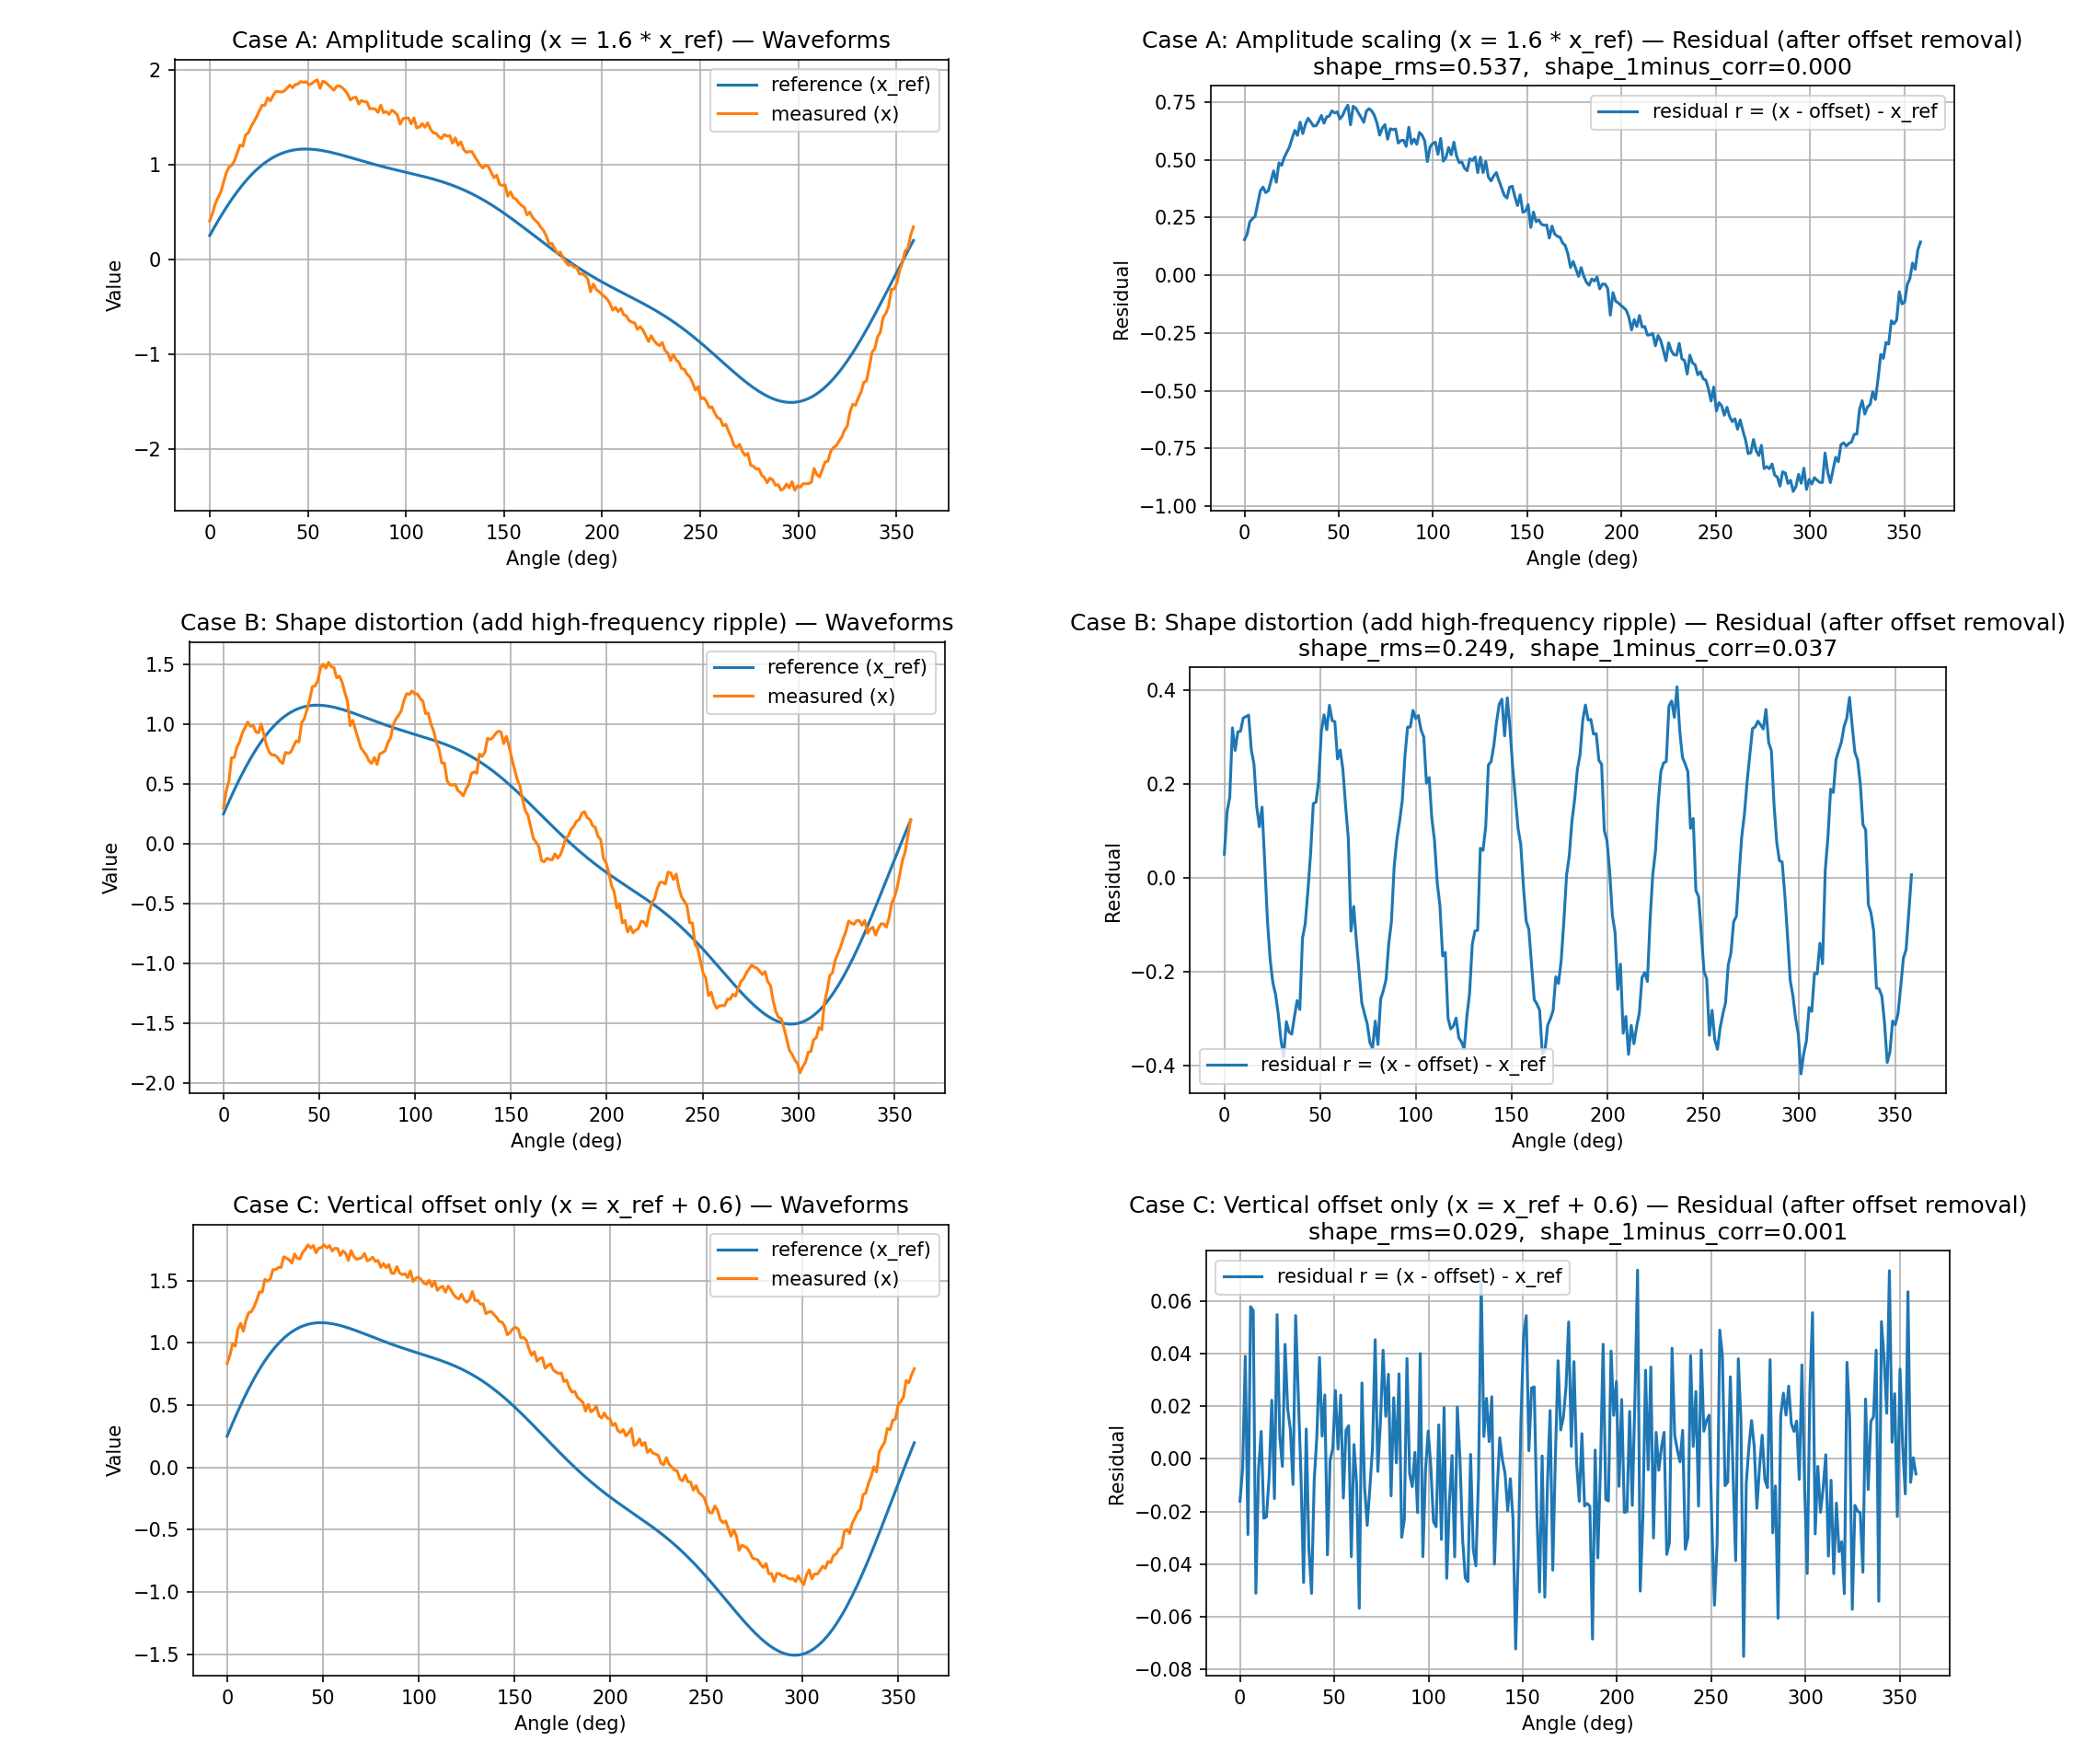

### この画像からわかる 2つの特徴量の違い

#### 定義（この図の右側で使っている量）
- 残差：r = (x - offset) - x_ref   （offset は mean(x - x_ref)）
- shape_rms：残差 r の「平均的な大きさ」
- shape_1minus_corr：上下補正後の波形 (x - offset) と参照 x_ref の「形の似てなさ」
  （1 - 相関。0に近いほど似ている）

---

#### 画像の3ケースでの挙動

##### Case A: Amplitude scaling（倍率変化）
- 左（Waveforms）：参照と測定は「形は同じ」だが、測定の振幅が大きい（全体が1.6倍）
- 右（Residual）：残差が 1周期を通して大きく残る（山も谷もズレが大きい）
- だから
  - shape_rms は大きくなる（例：0.537）
  - shape_1minus_corr はほぼ増えない（例：0.000）
- 解釈：**形は同じだが“量（振幅）”が変わった**を拾うのが shape_rms

---

##### Case B: Shape distortion（形状崩れ）
- 左（Waveforms）：参照に対して細かい波（高周波のうねり）が乗って「形が違う」
- 右（Residual）：残差が細かく周期的に振れる（形の差が残る）
- だから
  - shape_1minus_corr が Case A より増える（例：0.037）
  - shape_rms も増えるが、Case A ほどは大きくない（例：0.249）
- 解釈：**“形が崩れた”を拾うのが shape_1minus_corr**

---

##### Case C: Vertical offset only（上下シフトだけ）
- 左（Waveforms）：参照に一定値を足しただけ（全体が上に持ち上がる）
- 右（Residual）：offset を引くので残差はほぼノイズだけ
- だから
  - shape_rms は小さい（例：0.029）
  - shape_1minus_corr も小さい（例：0.001）
- 解釈：**上下シフトは offset で消えるので shape_* には残らない**

---

### 結論（違いを一言で）
- shape_rms：**ズレの量（残差の振れ幅）**を見る → 倍率変化で大きくなる
- shape_1minus_corr：**形の違い（うねり・歪み）**を見る → 形状崩れで大きくなる

## 3) 1サイクルごとの特徴量をまとめて計算（例）

ここでは「LS由来（不等間隔）」と「ビン化由来（整列・残差）」を同じ行にまとめる例を示す。


In [14]:
import pandas as pd
import numpy as np

# ============================================================
# 参照波形（train正常）を作る
# ============================================================
x_ref, m_ref = build_reference_waveform_from_train(
    Xtr_nan, Mtr, ytr,
    label_normal=0,
    min_valid_per_bin=10,
)

print("[reference]")
print("x_ref shape:", x_ref.shape, "valid bins:", int(m_ref.sum()))

# ============================================================
# 1サイクルの特徴量をまとめて計算する（集約関数）
#   ※「特徴量1つ=関数1つ」は上で満たしているので、ここはただのまとめ
# ============================================================
def compute_features_for_cycle(cycles_dict, Xnan, M, cids, x_ref, m_ref,
                               k_min=1, k_max=100,
                               low=(1,10), mid=(11,30), high=(31,100),
                               spike_k=6.0):
    rows = []
    for row_i, cid in enumerate(cids):
        deg_raw, y_raw, lab = cycles_dict[int(cid)]
        x_bin = Xnan[row_i]
        m_bin = M[row_i]

        # ---- 信頼度（ビン）----
        cov = feat_coverage(m_bin)
        miss = feat_miss_rate(m_bin)
        lg = feat_longest_gap(m_bin)
        nobs = feat_n_obs(m_bin)

        # ---- LS（不等間隔）----
        k_grid, Pk = ls_power_scipy_from_deg(deg_raw, y_raw, k_min=k_min, k_max=k_max)
        ls_feat = ls_features_from_power(k_grid, Pk, low=low, mid=mid, high=high)

        # ---- 位相・残差系（ビン化）----
        ph_deg  = feat_phase_shift_deg(x_bin, m_bin, x_ref, m_ref)
        ph_corr = feat_phase_corr_max(x_bin, m_bin, x_ref, m_ref)

        off_abs = feat_offset_abs(x_bin, m_bin, x_ref, m_ref)
        sh_rms  = feat_shape_rms(x_bin, m_bin, x_ref, m_ref)
        sh_1mc  = feat_shape_1minus_corr(x_bin, m_bin, x_ref, m_ref)

        sp_max  = feat_spike_max(x_bin, m_bin, x_ref, m_ref)
        sp_cnt  = feat_spike_count(x_bin, m_bin, x_ref, m_ref, k=spike_k)

        rows.append({
            "cycle_id": int(cid),
            "label": int(lab),

            # 信頼度（MSPCには入れない想定）
            "coverage": cov,
            "miss_rate": miss,
            "longest_gap": lg,
            "n_obs": nobs,

            # LS（周波数）
            **ls_feat,

            # 位相・形状・スパイク
            "phase_shift_deg": ph_deg,
            "phase_corr_max": ph_corr,
            "offset_abs": off_abs,
            "shape_rms": sh_rms,
            "shape_1minus_corr": sh_1mc,
            "spike_max": sp_max,
            "spike_count": sp_cnt,
        })
    return pd.DataFrame(rows)


# ---- 実行（train/test）----
df_feat_tr = compute_features_for_cycle(train_cycles, Xtr_nan, Mtr, cidtr, x_ref, m_ref)
df_feat_te = compute_features_for_cycle(test_cycles,  Xte_nan, Mte, cidte, x_ref, m_ref)

print("\n[features]")
print("train:", df_feat_tr.shape, "test:", df_feat_te.shape)
display(df_feat_tr.head())


[reference]
x_ref shape: (256,) valid bins: 256

[features]
train: (700, 18) test: (1020, 18)


,cycle_id,label,coverage,miss_rate,longest_gap,n_obs,ls_low,ls_mid,ls_high,ls_hl,ls_ml,phase_shift_deg,phase_corr_max,offset_abs,shape_rms,shape_1minus_corr,spike_max,spike_count
0,0,0,0.929688,0.070312,1,238,-6.827619,-9.061366,-8.673319,-1.845700,-2.233747,0.0,0.994318,0.010057,0.081296,0.005682,0.209736,0.0
1,1,0,0.960938,0.039062,1,246,-6.601226,-8.610167,-8.734218,-2.132992,-2.008941,0.0,0.993724,0.000149,0.084864,0.006276,0.240188,0.0
2,2,0,0.929688,0.070312,1,238,-6.944921,-8.646265,-8.776627,-1.831707,-1.701344,0.0,0.994988,0.001679,0.076897,0.005012,0.262073,0.0
3,3,0,0.941406,0.058594,1,241,-7.089314,-8.714992,-8.799202,-1.709888,-1.625678,0.0,0.994535,0.002539,0.080476,0.005465,0.234013,0.0
4,4,0,0.933594,0.066406,1,239,-7.091143,-8.643478,-8.726873,-1.635730,-1.552335,0.0,0.994796,0.004468,0.078037,0.005204,0.217735,0.0
